In [1]:
import numpy as np
import fitsio
import healpy as hp
import matplotlib.pyplot as plt
import Config
import tensorflow as tf
from matplotlib.colors import LogNorm

# CHANGE THESE PARAMETERS AS NEEDED

In [2]:
res = 4096 # Resolution of the heal pixels
widthBins = 0.025 # Width of the bins
numBins = 2500 # Number of bins to use
perVar = 0.98 # Percent of the variance to be captured
perMap = 0.625 # Percent of the PC maps to use, adjust this later

In [3]:
# This is the actual file containing all of the data
starFile = '/afs/hep.wisc.edu/bechtol-group/MegansThings/balrog_detection_catalog_sof_run2_stars_v1.4_avg_added_match_flags.fits'
# This reads in all of the data. Most of these are just flags, the only pieces that get used much outside
# of filtering are detected, true_ra and true_dec which get used to convert into healPixels.
starData = fitsio.read(starFile, columns = ['detected', 'true_ra', 'true_dec',
                                            'flags_foreground', 'flags_badregions', 'flags_footprint',
                                            'meas_FLAGS_GOLD_SOF_ONLY', 'match_flag_1.5_asec'])

In [4]:
# These are in degrees which is why lonlat is set to True in the next cell.
RA = starData['true_ra']
DEC = starData['true_dec']
# This is used for detection rates, each point is either a 0 (no detection) or a 1 (detection)
DETECTED = starData['detected']
# Everything from here on out is simply used in order to filter the data
FOREGROUND = starData['flags_foreground']
BADREGIONS = starData['flags_badregions']
FOOTPRINT = starData['flags_footprint']
GOLDSOF = starData['meas_FLAGS_GOLD_SOF_ONLY']
ARCSECONDS = starData['match_flag_1.5_asec']

# This is used to filter out any injections that either weren't detected or had flags raised.
cutIndices = np.where((FOREGROUND == 0) & 
                      (BADREGIONS < 2) & 
                      (FOOTPRINT == 1) & 
                      (ARCSECONDS < 2))[0]

# This reduced the data down to the actually valid pixels.
DETECTED = DETECTED[cutIndices]
RA = RA[cutIndices]
DEC = DEC[cutIndices]

In [5]:
# This converts the RA and DEC values from above to healpixels so we can compare to the sky condition.
starPixels = hp.ang2pix(res, RA, DEC, lonlat = True, nest = True)

In [6]:
# This sorts by the pixel in order to make following methods more efficient.
sortInds = starPixels.argsort()
starPix = starPixels[sortInds[::1]]
DET = DETECTED[sortInds[::1]]

In [7]:
# These are indices that will be looping through the pixStar and starPix arrays in parallel.
uniqInd = 0
starInd = 0

# This will be used to store the number of stars at each pixel.
pixStar = np.unique(starPix) # The unique pixels, with no repeats.
detStar = np.zeros_like(pixStar)
injStar = np.zeros_like(pixStar)

while starInd < len(starPix):
    if pixStar[uniqInd] == starPix[starInd]: # If the pixels match up in the arrays.
        detStar[uniqInd] += DET[starInd]     # Add one if there was a detection at this location.
        injStar[uniqInd] += 1                # Add one to the corresponding spot in the balStar array.
        starInd += 1                         # Add one to the starInd to see if the next index in starPix is also the same.
        # Since the last index of pixStar and starPix are the same, starInd will increase the last time through the loop,
        # making this the index that we must restrict in the while loop.
    else:
        uniqInd += 1 # If the pixels are no longer the same, increase the index you check in the pixStar array.
        
# This loads in all of the file names of the survey conditions
condFiles = Config.files
condMapsExt = []

# This loops over every condition file except for stellar density which has a different format
for i in range(len(condFiles) - 1):
    condData = fitsio.read(condFiles[i]) # This reads in the data
    condSigExt = np.full(12*(4096**2), -1.6375e+30) # Gives a default value
    condSigExt[condData['PIXEL']] = condData['SIGNAL'] # Changes all valid pixels to their corresponding signals
    condSigExt[np.where(condSigExt == -1.6375e+30)[0]] = hp.UNSEEN # Masks all non valid pixels
    if res != 4096:
        condSigExt=hp.ud_grade(condSigExt, res) # Only degrades if necessary (this is very time consuming)
    condMapsExt.append(condSigExt[pixStar]) # Only stores the values that are in pixels with injections
    
stelDensExt = fitsio.read(condFiles[-1])['I'].flatten() # Loads in the stellar density
stelDensExt[np.where(stelDensExt < 0)[0]] = hp.UNSEEN # Masks all non valid pixels
if res != 4096:
    stelDensExt=hp.ud_grade(stelDensExt, res) # Degrades if necessary
condMapsExt.append(stelDensExt[pixStar])

condMapsExt = np.array(condMapsExt, dtype = object) # Converts to an array

validIndices = np.full(len(pixStar), True, dtype = bool)
# The only valid indices are ones where every survey property is unmasked
for cond in condMapsExt:
    tempValidIndices = np.full(len(pixStar), True, dtype = bool)
    tempValidIndices[np.where(cond < -1000000000)[0]] = False
    validIndices = validIndices & tempValidIndices
    
condMaps = []
# Degrades all of the values to a common set of pixels
pixStar = pixStar[validIndices]
detStar = detStar[validIndices]
injStar = injStar[validIndices]

for cond in condMapsExt:
    condMaps.append(cond[validIndices])
    
condMaps = np.array(condMaps)

In [8]:
stanMaps = []
averages = []
stanDevs = []
# This standardizes every map as a first step of PCA
for cond in condMaps:
    averages.append(np.average(cond))
    stanDevs.append(np.std(cond))
    stanMaps.append((cond - np.average(cond)) / np.std(cond))
    
stanMaps = np.array(stanMaps)

In [9]:
# This gives the covariance matrix of the standardized maps
# Bias is true since the variance of each individual standardized map should be 1
cov = np.cov(stanMaps.astype(float), bias = True)

In [10]:
# This gives the eigenvalues and vectors of the covariance matrix
evalues, evectors = np.linalg.eig(cov)

In [11]:
# This cuts after the specified percentage of the variance has been achieved
for i in range(len(evalues)):
    if np.sum(evalues[0:i+1]) / np.sum(evalues) >= perVar:
        cutoff = i + 1
        break
featVec = evectors[0:cutoff]

In [12]:
redMaps = np.matmul(featVec, stanMaps) # Reduces the maps to PCA maps

In [13]:
# Stores the original data for later comparisons
originalDetStar = detStar
originalInjStar = injStar
aveEff = np.sum(originalDetStar) / np.sum(originalInjStar)

In [14]:
# Goal of this method is to find the index of the map that has the largest impact on detection rates.
def mostSigPCMap(redMaps, detStar, injStar = injStar, numBins = numBins, widthBins = widthBins):
    
    maxAdjustment = []

    for i in range(len(redMaps)):
        
        onePC = redMaps[i] # Load up a PC map

        binIndLims = []

        binSize = int(widthBins * len(onePC))
        binIndLims.append([0, binSize])

        binsRemaining = numBins - 1

        while binsRemaining > 0:
            endSpot = int((len(onePC) - binIndLims[-1][1]) / binsRemaining) + binIndLims[-1][1]
            binIndLims.append([endSpot - binSize, endSpot])
            binsRemaining -= 1

        # Sort detections and injections by the PC map value.
        sortInds = onePC.argsort()
        detStarTemp = detStar[sortInds[::1]]
        injStarTemp = injStar[sortInds[::1]]

        detBins = []
        injBins = []

        # Bin up these detections and injections.
        for j in range(numBins):
            detBins.append(detStarTemp[binIndLims[j][0]:binIndLims[j][1]])
            injBins.append(injStarTemp[binIndLims[j][0]:binIndLims[j][1]])

        yValues = []

        # For each bin find the detection rate relative to the average.
        for j in range(numBins):
            yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)

        yValues = np.array(yValues)
        
        # Make the error the sum of the squared difference between the binned values and 1.
        maxAdjustment.append(np.sum((yValues - 1)**2))
        
    maxAdjustment = np.array(maxAdjustment)
    
    mostSigIndex = np.where(maxAdjustment == np.max(maxAdjustment))[0]
    
    return mostSigIndex[0] # Return wherever the error is the largest

In [15]:
detStar = originalDetStar

In [16]:
trimRedMaps = np.copy(redMaps)

iterations = int(perMap * len(redMaps))
    
for _ in range(iterations):

    index = mostSigPCMap(trimRedMaps, detStar)
    
    condMapIndex = np.array(trimRedMaps[index])
    
    sortInds = condMapIndex.argsort()
    condMap = condMapIndex[sortInds[::1]]
    detStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]
    
    binIndLims = []

    binSize = int(widthBins * len(condMap))
    binIndLims.append([0, binSize])

    binsRemaining = numBins - 1

    while binsRemaining > 0:
        endSpot = int((len(condMap) - binIndLims[-1][1]) / binsRemaining) + binIndLims[-1][1]
        binIndLims.append([endSpot - binSize, endSpot])
        binsRemaining -= 1
        
    detBins = []
    injBins = []
    condBins = []

    for j in range(len(binIndLims)):
        detBins.append(detStarTemp[binIndLims[j][0]:binIndLims[j][1]])
        injBins.append(injStarTemp[binIndLims[j][0]:binIndLims[j][1]])
        condBins.append(condMap[binIndLims[j][0]:binIndLims[j][1]])

    yValues = []
    xValues = []

    for j in range(len(binIndLims)):
        yValues.append((np.sum(detBins[j]) / np.sum(injBins[j])) / aveEff)
        xValues.append(np.sum(condBins[j] * injBins[j]) / np.sum(injBins[j]))

    xValues = np.array(xValues)
    yValues = np.array(yValues)
    
    model = tf.keras.models.Sequential([
      tf.keras.layers.Dense(20, activation='relu', input_shape = (1,)),
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.Dense(20, activation='relu'),
      tf.keras.layers.Dense(1)
    ])
    
    inValues = (xValues - np.average(xValues)) / np.std(xValues)
    outValues = (yValues - np.average(yValues)) / np.std(yValues)
    
    model.compile(optimizer = 'adam', loss = 'mean_squared_error')
    model.fit(x = inValues, y = outValues, epochs = 150, verbose = 0)
    
    corrValues = ((np.array(model(((condMapIndex - np.average(xValues)) / np.std(xValues)).astype(float))) * np.std(yValues)) + np.average(yValues))[:,0]
    
    detStar = detStar / corrValues

    pcMapCutoff = np.full(len(trimRedMaps), True, dtype = bool)
    pcMapCutoff[index] = False
    trimRedMaps = trimRedMaps[pcMapCutoff]

2022-08-25 17:13:23.218857: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


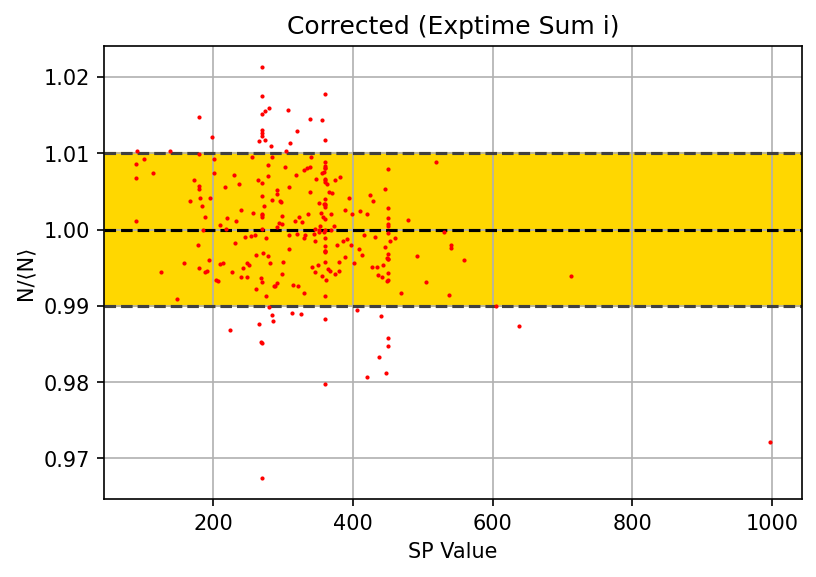

In [17]:
oneMap = condMaps[Config.exptimeSUMi]

numBinsTest = 250
binIndLims = [0]

for i in range(numBinsTest):
    binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

sortInds = oneMap.argsort()
oneMap = oneMap[sortInds[::1]]
detStarTemp = detStar[sortInds[::1]]
injStarTemp = injStar[sortInds[::1]]

detBins = []
injBins = []
mapBins = []

for i in range(numBinsTest):
    detBins.append(detStarTemp[binIndLims[i]:binIndLims[i+1]])
    injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
    mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

yValues = []
xValues = []

for i in range(numBinsTest):
    yValues.append((np.sum(detBins[i]) / np.sum(injBins[i])) / aveEff)
    xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

xValues = np.array(xValues)
yValues = np.array(yValues)

plt.figure(dpi = 150)
plt.scatter(xValues, yValues, s = 1, zorder = 3, color = 'r')
plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
plt.xlim(plt.gca().get_xlim())
#plt.fill_between(plt.gca().get_xlim(), 0.98, 1.02, color = (176/256,141/256,87/256))
#plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = (192/256,192/256,192/256))
plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
# plt.ylim([0.98, 1.02])
plt.xlabel('SP Value')
plt.ylabel('N/⟨N⟩')
plt.title('Corrected (Exptime Sum i)')
plt.grid(zorder = 0)
plt.show()

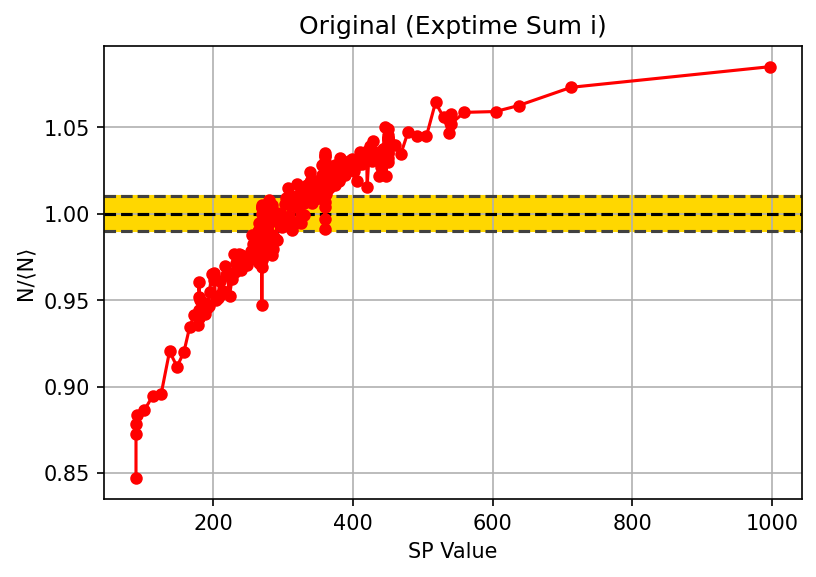

In [18]:
oneMap = condMaps[Config.exptimeSUMi]

binIndLims = [0]

for i in range(numBinsTest):
    binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

sortInds = oneMap.argsort()
oneMap = oneMap[sortInds[::1]]
detStarTemp = originalDetStar[sortInds[::1]]
injStarTemp = injStar[sortInds[::1]]

detBins = []
injBins = []
mapBins = []

for i in range(numBinsTest):
    detBins.append(detStarTemp[binIndLims[i]:binIndLims[i+1]])
    injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])
    mapBins.append(oneMap[binIndLims[i]:binIndLims[i+1]])

yValues = []
xValues = []

for i in range(numBinsTest):
    yValues.append((np.sum(detBins[i]) / np.sum(injBins[i])) / aveEff)
    xValues.append(np.sum(mapBins[i] * injBins[i]) / np.sum(injBins[i]))

xValues = np.array(xValues)
yValues = np.array(yValues)

plt.figure(dpi = 150)
plt.plot(xValues, yValues, marker = '.', ms = 10, zorder = 3, color = 'r')
plt.axhline(y = 1, color = 'k', linestyle = '--', zorder = 2)
plt.axhline(y = 1.01, color = '0.25', linestyle = '--', zorder = 2)
plt.axhline(y = 0.99, color = '0.25', linestyle = '--', zorder = 2)
plt.xlim(plt.gca().get_xlim())
# plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'silver')
plt.fill_between(plt.gca().get_xlim(), 0.99, 1.01, color = 'gold')
plt.xlabel('SP Value')
plt.ylabel('N/⟨N⟩')
plt.title('Original (Exptime Sum i)')
plt.grid(zorder = 0)
plt.show()

In [19]:
maxError = []

for cond in condMaps:
    
    oneMap = cond
    
    binIndLims = [0]

    for i in range(numBinsTest):
        binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

    sortInds = oneMap.argsort()
    corDetStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    corDetBins = []
    injBins = []

    for i in range(numBinsTest):
        corDetBins.append(corDetStarTemp[binIndLims[i]:binIndLims[i+1]])
        injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])

    yValuesCor = []

    for i in range(numBinsTest):
        yValuesCor.append((np.sum(corDetBins[i]) / np.sum(injBins[i])) / aveEff)

    yValuesCor = np.array(yValuesCor)
    
    maxError.append(np.max(np.abs(yValuesCor - 1)))
    
maxError = np.array(maxError)

In [20]:
print(np.average(maxError))
print(np.max(maxError))

0.06506228593239168
0.2829503530144448


In [21]:
aveError = []

for cond in condMaps:
    
    oneMap = cond
    
    binIndLims = [0]

    for i in range(numBinsTest):
        binIndLims.append(int((len(oneMap) - binIndLims[-1]) / (numBinsTest - i)) + (binIndLims[-1]))

    sortInds = oneMap.argsort()
    corDetStarTemp = detStar[sortInds[::1]]
    injStarTemp = injStar[sortInds[::1]]

    corDetBins = []
    injBins = []

    for i in range(numBinsTest):
        corDetBins.append(corDetStarTemp[binIndLims[i]:binIndLims[i+1]])
        injBins.append(injStarTemp[binIndLims[i]:binIndLims[i+1]])

    yValuesCor = []

    for i in range(numBinsTest):
        yValuesCor.append((np.sum(corDetBins[i]) / np.sum(injBins[i])) / aveEff)

    yValuesCor = np.array(yValuesCor)
    
    aveError.append(np.average(np.abs(yValuesCor - 1)))
    
aveError = np.array(aveError)

In [22]:
print(np.average(aveError))
print(np.max(aveError))

0.00671656036468498
0.009458294593800126


In [23]:
np.where(aveError == np.min(aveError))[0]

array([60])